# Mamba MCMC for an LMM with one simple, scalar term

In [1]:
Pkg.update();
addprocs(4);
using Compat,DataFrames,Distributions,GraphViz,Mamba,RDatasets,StatsBase

INFO: Updating METADATA...
INFO: Updating Interact...
INFO: Updating JuliaBox...
INFO: Updating Homework...
INFO: Computing changes...
INFO: No packages to install, update or remove


In [2]:
#ds = DataFrames.DataFrame("lme4::Dyestuff")
ds = dataset("lme4","Dyestuff")
dump(ds)

DataFrame  30 observations of 2 variables
  Batch: PooledDataArray{ASCIIString,Uint8,1}(30) ASCIIString["A","A","A","A"]
  Yield: DataArray{Int32,1}(30) Int32[1545,1440,1440,1520]


Create a `Dict{Symbol,Any}` containing the response and model matrices `X`, for the fixed-effects, and `Z`, for the random effects.

In [12]:
dsmod = Model(
  μ = Logical(1, @modelexpr(β,b,Xt,Zt,vec(Xt'β+Zt'b)), false),
  y = Stochastic(1, @modelexpr(μ,σ²,MvNormal(μ,sqrt(σ².value))),false),
  σ² = Stochastic(:(InverseGamma(0.001,0.001))),
  σ₁² = Stochastic(:(InverseGamma(0.001,0.001))),
  β = Stochastic(:(Flat())),
  b = Stochastic(1, @modelexpr(σ₁², MvNormalCanon(6, inv(σ₁².value))), false)
);

In [13]:
draw(dsmod,filename="foo.dot");

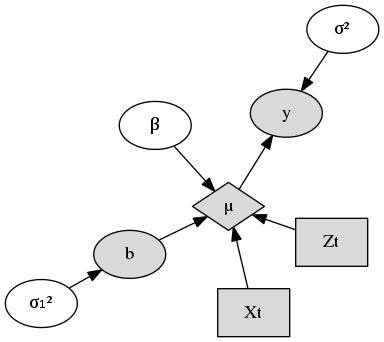

In [14]:
open("foo.dot","r") do io Graph(io) end

In [15]:
inputs = @compat Dict{Symbol,Any}(
  :Zt => convert(Matrix{Float64},StatsBase.indicatormat(ds[:Batch])),
  :Xt => ones(1,30)
);

Technically `y` is not an input because it is a stochastic node.  We initialize it to a constant 

In [16]:
inits = [
    @compat Dict{Symbol,Any}(
        :y => convert(Vector{Float64},array(ds[:Yield])),
        :σ² => rand(Normal(2500,10)),
        :σ₁² => rand(Normal(1500,10)),
        :β => mean(ds[:Yield]),
        :b => [-16.6282, 0.369516, 26.9747, -21.8014, 53.5798, -42.4943]) for i in 1:4];

In [17]:
setsamplers!(dsmod,[NUTS([:β,:σ²,:σ₁²])]);

In [18]:
sim = mcmc(dsmod, inputs, inits, 10000, burnin=2000, thin=2, chains=4, verbose=false);

	From worker 2:	
	From worker 5:	
	From worker 4:	
	From worker 3:	


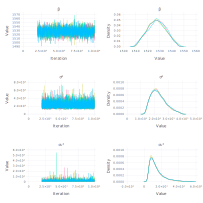

In [19]:
draw(plot(sim))

In [20]:
describe(sim)

Iterations = 2002:10000
Thinning interval = 2
Chains = 1,2,3,4
Samples per chain = 4000

Empirical Posterior Estimates:
4x6 Array{Any,2}:
 ""                     "Mean"  …    "Naive SE"    "MCSE"        "ESS"
 "\u3b2"            1527.44         0.0684575     0.156683   3054.36  
 "\u3c3\ub2"        2313.47         5.13872       5.09766   16000.0   
 "\u3c3\u2081\ub2"  1557.23        11.7063       15.6829     8914.66  

Quantiles:
4x6 Array{Any,2}:
 ""                     "2.5%"      "25.0%"  …      "75.0%"      "97.5%"
 "\u3b2"            1510.56     1521.72         1533.16      1544.79    
 "\u3c3\ub2"        1377.94     1858.46         2645.47      3887.38    
 "\u3c3\u2081\ub2"   431.132     787.645        1792.58      5350.55    
